In [23]:
# Imports
from pathlib import Path
import os
import rasterio
from rasterio.windows import Window
import PIL
import torchvision
import numpy
import cv2
import skimage
from itertools import product
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from albumentations import PadIfNeeded
import pandas as pd
from tqdm import tqdm
import shutil
from animaloc.data import ImageToPatches, PatchesBuffer, save_batch_images

In [2]:
from pathlib import Path
import os
import random

# Splitting data for annotation

### For GeoTiffs

In [ ]:
def save_patches(img_path:Path,dest_dir:Path,tilesize=512):

    # create directory
    if os.path.exists(dest_dir):
        shutil.rmtree(dest_dir)
        os.mkdir(dest_dir)
        print("emptying directory:", dest_dir)
    else:
        os.mkdir(dest_dir)
        print("creating directory:", dest_dir)
    
    # window reading with rasterio
    handler = rasterio.open(img_path)
    height, width = handler.meta['height'], handler.meta['width']
    coordinates = dict()
    count = 0
    for i,j in tqdm(product(list(range(0,height,tilesize)),list(range(0,width,tilesize)))):
        window = Window(j, i, tilesize, tilesize)
        
        try:
            chunk = handler.read(window=window)
            c,h,w = chunk.shape
            xmin, xmax = j, j+w
            ymin, ymax = i, i+h
            x_center = 0.5*(xmin+xmax)
            y_center = 0.5*(ymin+ymax)
            n_unique = np.unique(chunk).size
            if n_unique == 1:
                continue
            count += 1
            filename = img_path.name.split('.')[0] + f"-{j}-{i}.png"
            coordinates[count] = [xmin,xmax,ymin,ymax,x_center,y_center,filename]

            # save to disk
            chunk = np.transpose(chunk,(1,2,0))
            skimage.io.imsave(dest_dir/filename,chunk)          
                
        except Exception as e:
            print("Failed for",(i,j),e)
            pass

    cols = ['xmin','xmax','ymin','ymax','x_center','y_center','filename']
    coordinates = pd.DataFrame.from_dict(coordinates,
                                        orient='index',
                                        columns=cols)
    coordinates.to_csv(dest_dir/f"coordinates{img_path.name.split('.')[0]}.csv",index=False)
    handler.close()
    return coordinates

In [69]:
# for datapath in Path("../annotation_data/camp6/").iterdir():
datapath = Path("../annotation_data/camp6/150m_RGB.tif")
dest_dir = datapath.parent/(datapath.name.split('.')[0])
# coordinates =  save_patches(datapath,dest_dir,tilesize=1024)

emptying directory: ../annotation_data/camp6/150m_RGB


126it [01:09,  1.82it/s]


In [70]:
coordinates

,xmin,xmax,ymin,ymax,x_center,y_center,filename
1,0,1024,0,1024,512.0,512.0,150m_RGB-0-0.png
2,1024,2048,0,1024,1536.0,512.0,150m_RGB-1024-0.png
3,2048,3072,0,1024,2560.0,512.0,150m_RGB-2048-0.png
4,3072,4096,0,1024,3584.0,512.0,150m_RGB-3072-0.png
5,4096,5120,0,1024,4608.0,512.0,150m_RGB-4096-0.png
...,...,...,...,...,...,...,...
112,2048,3072,8192,8612,2560.0,8402.0,150m_RGB-2048-8192.png
113,3072,4096,8192,8612,3584.0,8402.0,150m_RGB-3072-8192.png
114,4096,5120,8192,8612,4608.0,8402.0,150m_RGB-4096-8192.png
115,5120,6144,8192,8612,5632.0,8402.0,150m_RGB-5120-8192.png


### For Images (jpg, rgb etc.)
Using Herdnet code

In [6]:
!pwd # current working dir

/home/ubuntu/workspace/HerdNet


In [11]:
# splitting validation data
Path("../general_dataset/val_splits").mkdir(exist_ok=True,parents=True)

!python ./tools/patcher.py ../general_dataset/val 640 640 100 \
    ../general_dataset/val_splits \
    -csv ../general_dataset/groundtruth/csv/val_big_size_A_B_E_K_WH_WB.csv \
    -min 0.0 -all False

Exporting patches: 100%|██████████████████████| 111/111 [06:00<00:00,  3.25s/it]


In [40]:
# splitting training data
Path("../general_dataset/train_splits").mkdir(exist_ok=True,parents=True)

!python ./tools/patcher.py ../general_dataset/train 640 640 100 \
    ../general_dataset/train_splits \
    -csv ../general_dataset/groundtruth/csv/train_big_size_A_B_E_K_WH_WB.csv \
    -min 0.0 -all False

Exporting patches:  27%|█████▉                | 248/928 [13:09<36:35,  3.23s/it]

In [ ]:
# splitting test data
Path("../general_dataset/test_splits").mkdir(exist_ok=True,parents=True)

!python ./tools/patcher.py ../general_dataset/test 640 640 100 \
    ../general_dataset/test_splits \
    -csv ../general_dataset/groundtruth/csv/test_big_size_A_B_E_K_WH_WB.csv \
    -min 0.0 -all False

### Sampling emtpy and non empty images

In [4]:
# sample training data

directory = Path(r"../wildlife_localizer_data/train")
labels = directory/'labels'
dest_images = directory/'images_nonempty'
source_images = directory/'images'

# create destination images
dest_images.mkdir(exist_ok=True)

# move non empty images
# -- Uncomment to run > Be careful
# for file in labels.iterdir():
#     img_name = file.name.split('.')[0]+'.JPG'
#     if (source_images/img_name).exists():
#         os.rename(src=source_images/img_name,
#                 dst=dest_images/img_name)

# and empty 
# num_non_empty = len(list(labels.iterdir()))
# num_empty_target = num_non_empty
# empty_images = list(source_images.iterdir())
# random.seed(41) # seeding for reproducibility
# random.shuffle(empty_images) # shuffle
# for file in empty_images[:num_empty_target]:
#     img_name = file.name
#     os.rename(src=file,
#                 dst=dest_images/img_name)

In [8]:
len(list(Path("../wildlife_localizer_data/train/images_nonempty").iterdir())),\
    len(list(Path("../wildlife_localizer_data/train/images").iterdir())),\
        len(list(Path("../wildlife_localizer_data/train/labels").iterdir()))


(10372, 66970, 5186)

# Visualizing data

In [2]:
import albumentations as A
from animaloc.datasets import CSVDataset
from animaloc.data.transforms import MultiTransformsWrapper, DownSample, PointsToMask, FIDT
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [13]:
# patch_size = 640
# num_classes = 7
down_ratio = 1

val_dataset = CSVDataset(
    csv_file = '../wildlife_localizer_data/val/gt.csv',
    root_dir = '../wildlife_localizer_data/val',
    albu_transforms = [A.Normalize(p=1.0)],
    end_transforms = [DownSample(down_ratio=down_ratio, anno_type='bbox')]
    )

In [18]:
val_dataset.anno_type

'BoundingBox'

In [14]:
labels = pd.read_csv('../wildlife_localizer_data/val/gt.csv')
labels.head()

,images,labels,base_images,x_min,y_min,x_max,y_max
0,005c952ba7a612c40986806cc84a87e1573ef4f2_13.JPG,6,005c952ba7a612c40986806cc84a87e1573ef4f2.JPG,243,255,283,307
1,005c952ba7a612c40986806cc84a87e1573ef4f2_15.JPG,6,005c952ba7a612c40986806cc84a87e1573ef4f2.JPG,399,254,452,302
2,005c952ba7a612c40986806cc84a87e1573ef4f2_23.JPG,6,005c952ba7a612c40986806cc84a87e1573ef4f2.JPG,293,283,339,308
3,031833f31b1622ec6701b7433a1664231f401d73_4.JPG,6,031833f31b1622ec6701b7433a1664231f401d73.JPG,183,144,226,181
4,031833f31b1622ec6701b7433a1664231f401d73_4.JPG,6,031833f31b1622ec6701b7433a1664231f401d73.JPG,118,275,157,295


In [12]:
np.sort(labels['labels'].unique())

array([1, 2, 3, 4, 5, 6])

In [24]:
# loader = DataLoader(dataset = val_dataset, batch_size = 1, shuffle = False)

In [4]:
images, targets = val_dataset[0]

In [5]:
targets

{'labels': tensor([6]),
 'base_images': ['005c952ba7a612c40986806cc84a87e1573ef4f2.JPG'],
 'boxes': tensor([[243., 255., 283., 307.]]),
 'image_id': [0],
 'image_name': ['005c952ba7a612c40986806cc84a87e1573ef4f2_13.JPG']}

In [39]:
# img = np.transpose(images.numpy(),(1,2,0))
# plt.imshow(img)

# Creating YOLO labels

In [13]:
# Images dimensions
height,width = 640, 640

# Create label directory
for directory in Path("../wildlife_localizer_data/").iterdir():
    if not directory.is_dir():
        continue 
    labels_dir = Path(os.path.join(directory,'labels'))
    labels_dir.mkdir(exist_ok=True,parents=False) # create directory if it does not exist
    labels = pd.read_csv(os.path.join(directory,'gt.csv'))
    #-- Saving labels in YOLO format
    for img_filename,df_group in tqdm(labels.groupby(by='images'),desc=directory.name):
        df_group['width'] = (df_group['x_max'] - df_group['x_min'])/width 
        df_group['height'] = (df_group['y_max'] - df_group['y_min'])/height
        df_group['x'] = (0.5*(df_group['x_min'] + df_group['x_max']))/width # x center
        df_group['y'] = (0.5*(df_group['y_min'] + df_group['y_max']))/height # y center
        df_group['labels'] = 0 

        # print('\n\n',directory.name,'\n',df_group[['labels','x','y','width','height']])
        # break

        # uncomment to save labels files
        labels_filename     = img_filename.split('.')[0] + '.txt'
        if len(df_group)>0:
            cols = ['labels','x','y','width','height']
            df_group[cols].to_csv(os.path.join(labels_dir,labels_filename),
                                    sep=" ",
                                    header=False,
                                    index=False)


test:   0%|          | 0/1633 [00:00<?, ?it/s]

train: 100%|██████████| 5186/5186 [00:22<00:00, 232.69it/s]


In [ ]:
# Control splitting
num_missing = 0
num_found = 0
num_total = 0
for path in Path("../wildlife_localizer_data/train/images").iterdir():
    filename = path.name.split('.')[0]
    labelpath = Path("../wildlife_localizer_data/train/labels")/(filename + '.txt')
    num_total += 1
    if not labelpath.exists():
        num_missing += 1
    else:
        num_found += 1

num_missing,num_found,num_total

In [7]:
labels = pd.read_csv(os.path.join(directory,'gt.csv'))
labels['labels'].unique()

array([6, 3, 2, 5, 4, 1])

# Savmap data
Saving bounding boxes in VOC format

In [80]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import torch 
from torchvision.utils import draw_bounding_boxes
from torchvision.ops import nms
from torchvision.transforms import PILToTensor
from PIL import Image

In [13]:
annotations_path = Path("../savmap_dataset/savmap_annotations_2014.shp")

In [26]:
data = gpd.read_file(annotations_path)
data.head()

,IMAGEUUID,TAGUUID,geometry
0,f77f4af5a1344b9086b307d2b4ba61ff,a9b3a2325dbe4a208bc3ae37eeb8e1e1,"POLYGON ((1197.000 568.000, 1186.000 568.000, ..."
1,33c79ba79aca4b06ae30a109e5cd868f,4999d35b3b8b407f8cbf48d95e689899,"POLYGON ((2689.000 778.000, 2674.000 747.000, ..."
2,12fe8b054f634ed0a0ffc5d7ed614b66,8d61ca1969b149cbaed4a9bd112c771f,"POLYGON ((3157.000 2721.000, 3224.000 2725.000..."
3,18c3f7ef05c74a849d2262786d71819e,5be6cc29725140b58e8d5fe5eba9b379,"POLYGON ((3559.000 2707.000, 3571.000 2708.000..."
4,18c3f7ef05c74a849d2262786d71819e,0093c3c4285a4eeaba82f29fb86b3c8a,"POLYGON ((437.000 606.000, 420.000 621.000, 42..."


In [21]:
data.loc[data['IMAGEUUID']=='0a3ed15cfab4453795564140e8fde8ba']

,IMAGEUUID,TAGUUID,geometry
1331,0a3ed15cfab4453795564140e8fde8ba,81364820730e4522b40d0671154b455a,"POLYGON ((1497.000 1099.000, 1487.000 1138.000..."
1332,0a3ed15cfab4453795564140e8fde8ba,1ae02c84e105442facdf4497d9a442dc,"POLYGON ((1485.000 1116.000, 1499.000 1163.000..."
1333,0a3ed15cfab4453795564140e8fde8ba,a1d14e6820184fb096c1321ae42d8694,"POLYGON ((1513.000 1115.000, 1515.000 1127.000..."
1334,0a3ed15cfab4453795564140e8fde8ba,575408a4bc7b4cd0aaf27b27d4a8985d,"POLYGON ((1505.000 1113.000, 1512.000 1114.000..."
1335,0a3ed15cfab4453795564140e8fde8ba,e5f1b5b28f6940a2b158ecc1dbbe0c56,"POLYGON ((1503.000 1112.000, 1516.000 1118.000..."
1336,0a3ed15cfab4453795564140e8fde8ba,21f18f6cbdce469f8d7ec7f736f42df0,"POLYGON ((1499.000 1121.000, 1506.000 1112.000..."
1337,0a3ed15cfab4453795564140e8fde8ba,63abd7fde0af45fab0ba3a699a13c562,"POLYGON ((2273.000 968.000, 2266.000 979.000, ..."


In [ ]:
uuid = '0a3ed15cfab4453795564140e8fde8ba'
polygons = data.loc[data['IMAGEUUID']==uuid,'geometry']
polygons

In [148]:
bboxes = dict()
count = 0
pil_to_tensor = PILToTensor()
for uuid in tqdm(np.unique(data.IMAGEUUID),desc='Getting bbox'):

    # identifier, filenmae w/o suffix
    uuid = str(uuid)

    # load img as tensor
    path_to_img = f"../savmap_dataset/{uuid}.JPG"
    img_pil = Image.open(path_to_img)
    img_tensor = pil_to_tensor(img_pil)

    # get boxes
    polygons = data.loc[data['IMAGEUUID']==uuid,'geometry']
    boxes = np.array([list(polygon.bounds) for polygon in polygons])
    boxes = torch.from_numpy(boxes).float()

    # apply non max suppression o discard overlaping polygons
    areas = (boxes[:,2] - boxes[:,0])*(boxes[:,3] - boxes[:,1])
    indices = nms(boxes=boxes,
                  scores= 1/areas, # discarding larger bbox when they overlap
                  iou_threshold=0.1)
    bbox = boxes[indices].numpy()

    # save bbox
    for i in range(count,count+bbox.shape[0]):
        bboxes[i] = [uuid,] + bbox[i-count].tolist()
    count = count+bbox.shape[0]
# print('retained bbox indes:',indices)

Getting bbox: 100%|██████████| 654/654 [02:19<00:00,  4.67it/s]


In [149]:
columns=['filename','xmin','ymin','xmax','ymax']
gt_bboxes = pd.DataFrame.from_dict(data=bboxes,
                       orient='index',
                       columns=columns)

for col in columns:
    if col != 'filename':
        gt_bboxes[col] = gt_bboxes[col].apply(int)
    else:
        gt_bboxes[col] = gt_bboxes[col].apply(lambda x: f"{x}.JPG")

gt_bboxes.head()

,filename,xmin,ymin,xmax,ymax
0,003a34ee6b7841e6851b8fe511ebe102.JPG,1679,858,1695,875
1,003a34ee6b7841e6851b8fe511ebe102.JPG,1503,962,1537,996
2,0078d29a8d0b489caa3425969c7477ac.JPG,2781,541,2822,577
3,0078d29a8d0b489caa3425969c7477ac.JPG,543,1725,603,1754
4,0078d29a8d0b489caa3425969c7477ac.JPG,620,1653,677,1689


In [150]:
# save bounding boxes
gt_bboxes.to_csv("../savmap_dataset/gt.csv",sep=',',index=False)

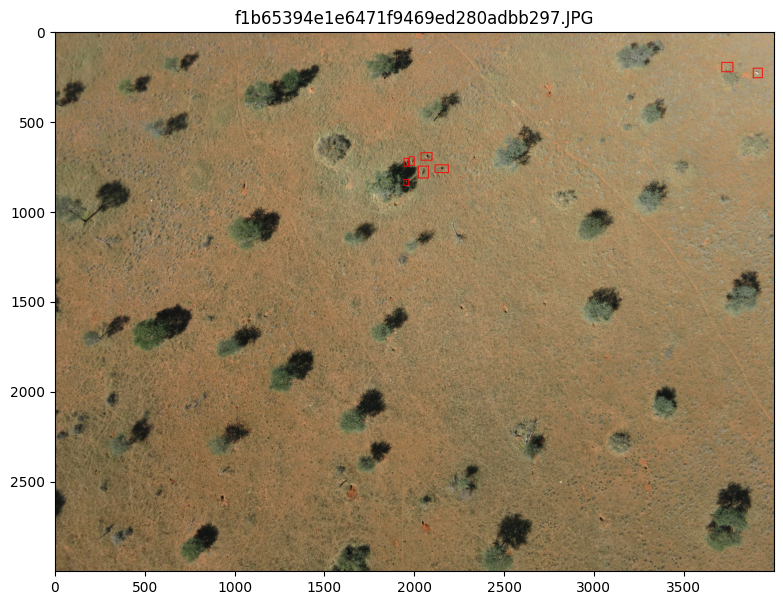

In [151]:
# Example: drawing bounding boxes

# load img as tensor
filename = gt_bboxes['filename'].sample(1).iloc[0]
path_to_img = f"../savmap_dataset/{filename}"
img_pil = Image.open(path_to_img)
img_tensor = PILToTensor()(img_pil)

boxes = gt_bboxes.loc[gt_bboxes['filename'] == filename, ['xmin','ymin','xmax','ymax']].to_numpy()
boxes = torch.from_numpy(boxes)

img_with_box = draw_bounding_boxes(img_tensor,
                                   boxes=boxes,
                                   colors="red",
                                   width=5).numpy().transpose((1,2,0))

plt.figure(figsize=(15,7))
plt.imshow(img_with_box)
plt.title(filename)
plt.show()